In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [76]:
df = pd.read_csv("Titanic (1).csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [77]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [78]:
df = df.dropna(subset=['Survived'])
X = df.drop('Survived', axis = 1)
y = df['Survived']

#added two random var
rng = np.random.RandomState(seed=42)
X["random_A"] = rng.randint(3, size=X.shape[0])
X["random_B"] = rng.randn(X.shape[0])

In [79]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

categorical_columns = ["Pclass", "Sex", "Embarked", "random_A"]
numerical_columns = ["Age", "SibSp", "Parch", "Fare", "random_B"]

#did a simple imputation to fill missing categorical var with mode. The only var missing is embarked with 2 missing values
X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])
enc = OrdinalEncoder()
X[categorical_columns] = enc.fit_transform(X[categorical_columns] )

#imputed numerical var missing values with mean
X[numerical_columns] = X[numerical_columns].apply(lambda x: x.fillna(np.mean(x)))

X = X[categorical_columns + numerical_columns]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [80]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf = 1,
         oob_score=True,
         random_state = 42)
rf.fit(X_train, y_train)

print(f"RF train accuracy: {rf.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {rf.score(X_test, y_test):.3f}")

RF train accuracy: 1.000
RF test accuracy: 0.758


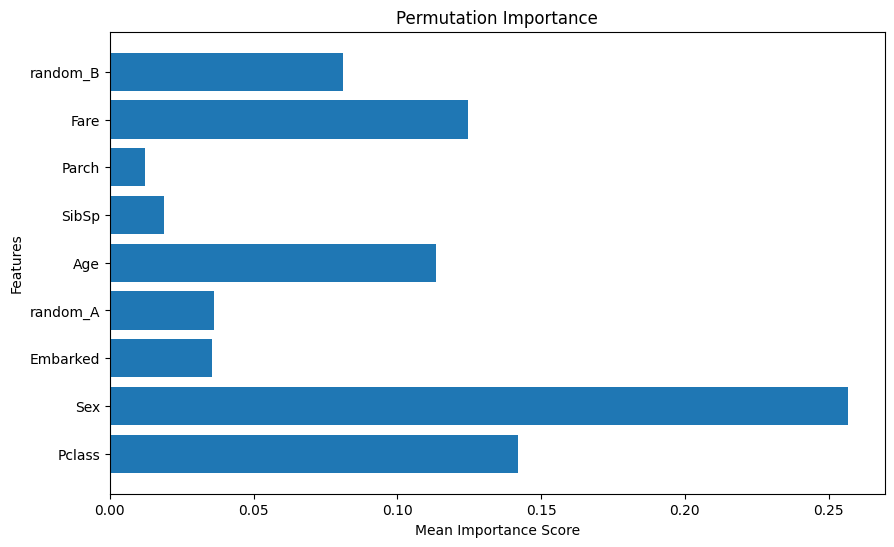

In [81]:
#Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset.
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_train, y_train, n_repeats=10, random_state=42)
importance_scores = result.importances_mean
feature_names = X_train.columns


plt.figure(figsize=(10, 6))
plt.barh(feature_names, importance_scores)
plt.xlabel('Mean Importance Score')
plt.ylabel('Features')
plt.title('Permutation Importance')
plt.show()

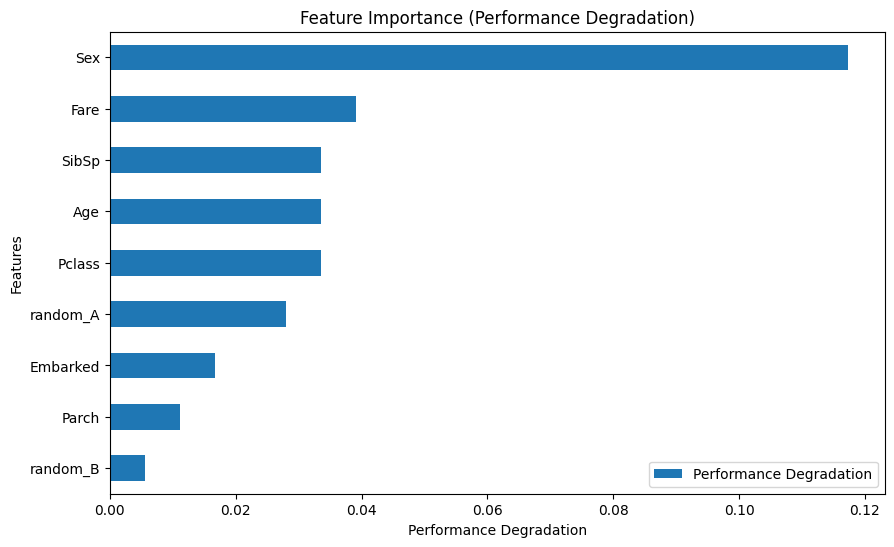

In [103]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

rf.fit(X_train, y_train)
baseline_accuracy = accuracy_score(y_val, rf.predict(X_val))

importance_scores = {}
for feature in X_train.columns:
    X_train_temp = X_train.drop(columns=[feature])
    X_val_temp = X_val.drop(columns=[feature])
    rf.fit(X_train_temp, y_train)
    accuracy_without_feature = accuracy_score(y_val, rf.predict(X_val_temp))
    importance_scores[feature] = baseline_accuracy - accuracy_without_feature

importance_df = pd.DataFrame.from_dict(importance_scores, orient='index', columns=['Performance Degradation'])
importance_df = importance_df.sort_values(by='Performance Degradation', ascending=True)

#Visualisation
importance_df.plot(kind='barh', figsize=(10, 6))
plt.xlabel('Performance Degradation')
plt.ylabel('Features')
plt.title('Feature Importance (Performance Degradation)')
plt.show()



In [102]:
#New Accuracy
threshold = 0.05
important_features = importance_df[importance_df['Performance Degradation'] > threshold].index


X_train_new = X_train.drop(columns=important_features)
X_val_new = X_val.drop(columns=important_features)
rf.fit(X_train_new, y_train)
new_accuracy = accuracy_score(y_val, rf.predict(X_val_new))

# Comparing the performance of the new model with the baseline model
print(f"Baseline Accuracy: {baseline_accuracy}")
print(f"New Accuracy after Feature Selection: {new_accuracy}")



Baseline Accuracy: 0.8547486033519553
New Accuracy after Feature Selection: 0.7374301675977654
